In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from datetime import datetime
from tqdm import trange

In [2]:
class PolicyEstimator():
    def __init__(self, n_observations, n_actions):
        self.num_observations = n_observations
        self.num_actions = n_actions

        self.network = nn.Sequential(
            nn.Linear(self.num_observations, 16),
            nn.ReLU(),
            nn.Linear(16, self.num_actions),
            nn.Softmax(dim=-1)
        )

    def predict(self, observation):
        return self.network(torch.FloatTensor(observation))


def plot_durations(show_result=False):
    fig = plt.figure(1, figsize=(6, 4))
    
    # griglia 2 righe: sopra grafico, sotto tabella
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
    ax_plot = fig.add_subplot(gs[0])
    ax_tab  = fig.add_subplot(gs[1])
    
    durations_t = torch.tensor(episode_durations, dtype=torch.float)

    if show_result:
        ax_plot.set_title('Result')
    else:
        fig.clf()
        ax_plot.set_title('Training...')
    

    ax_plot.set_xlabel('Episode')
    ax_plot.set_ylabel('Duration')
    ax_plot.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax_plot.plot(means.numpy())

    # --- TABELLA PARAMETRI ---
    ax_tab.axis('off')  # niente assi

    table_data = [
        ["BATCH_SIZE", BATCH_SIZE],
        ["GAMMA", GAMMA],
        ["LR", LR],
        ["Training time (s)", training_time],
        ["Max peak", max_peak],
        ["Maximal Peak Episode", max_peak_episode],
        ["Avg max peak", avg_max_peak],
        ["Avg Maximal Peak Episode", avg_max_episode],
    ]

    ax_tab.table(
        cellText=table_data,
        loc="center",
        cellLoc="center"
    )

    fig.tight_layout()

    plt.pause(0.001)

    if is_ipython:
        display.clear_output(wait=True)
        display.display(fig)


# Base model

In [3]:
episode_durations = []

### Main script ###
env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
LR = 1e-2

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = PolicyEstimator(n_observations, n_actions)

optimizer = optim.AdamW(policy_net.network.parameters(), lr=LR, amsgrad=True)
action_space = np.arange(env.action_space.n)

steps_done = 0


if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 15000
else:
    num_episodes = 15000

total_rewards, batch_rewards, batch_observations, batch_actions = [], [], [], []
batch_counter = 1

t1 = datetime.now()
training_time = 0
max_peak = 0
avg_max_peak = 0
max_peak_episode = 0
avg_max_episode = 0

pbar = trange(num_episodes, desc="Training episodes")

#for i_episode in range(num_episodes):
for i_episode in pbar:
    # Initialize the environment and get its state
    rewards, actions, observations = [], [], []
    observation, info = env.reset()
    #state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action_probs = policy_net.predict(observation).detach().numpy()
        action = np.random.choice(action_space, p=action_probs)  # randomly select an action weighted by its probability

        # push all episodic data, move to next observation
        observations.append(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)
        actions.append(action)

        done = terminated or truncated

        if done:
            #print(i_episode, t)
            #tqdm.write(f"Episode {i_episode}, steps: {t}")
            if t > max_peak:
                max_peak = t+1
                max_peak_episode = i_episode
            # apply discount to rewards
            r = np.full(len(rewards), GAMMA) ** np.arange(len(rewards)) * np.array(rewards)
            r = r[::-1].cumsum()[::-1]
            discounted_rewards = r - r.mean()

            # collect the per-batch rewards, observations, actions
            batch_rewards.extend(discounted_rewards)
            batch_observations.extend(observations)
            batch_actions.extend(actions)
            batch_counter += 1
            total_rewards.append(sum(rewards))

            if batch_counter >= BATCH_SIZE:
                # reset gradient
                optimizer.zero_grad()

                # tensorify things
                batch_rewards = torch.FloatTensor(batch_rewards)
                batch_observationss = torch.FloatTensor(batch_observations)
                batch_actions = torch.LongTensor(batch_actions)

                # calculate loss
                logprob = torch.log(policy_net.predict(batch_observations))
                batch_actions = batch_actions.reshape(len(batch_actions), 1)
                selected_logprobs = batch_rewards * torch.gather(logprob, 1, batch_actions).squeeze()
                loss = -selected_logprobs.mean()

                # backprop/optimize
                loss.backward()
                optimizer.step()

                # reset the batch
                batch_rewards, batch_observations, batch_actions = [], [], []
                batch_counter = 1

            # get running average of last 100 rewards, print every 100 episodes
            average_reward = np.mean(total_rewards[-100:])
            if i_episode % 100 == 0:
                #print(f"average of last 100 rewards as of episode {i_episode}: {average_reward:.2f}")
                #tqdm.write(f"Average last 100 rewards at episode {i_episode}: {average_reward:.2f}")
                if average_reward > avg_max_peak:
                    avg_max_peak = average_reward
                    avg_max_episode = i_episode

            pbar.set_postfix(
                episode=i_episode,
                steps=t,
                avg_reward=float(average_reward)
            )
            #
            # # quit early if average_reward is high enough
            # if early_exit_reward_amount and average_reward > early_exit_reward_amount:
            #     return total_rewards
            #
            # break

            episode_durations.append(t + 1)
            #plot_durations()
            break

t2 = datetime.now()
training_time = t2 - t1
training_time = int(training_time.total_seconds())
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

Training episodes:   1%|          | 101/15000 [00:00<00:44, 333.04it/s, avg_reward=21.5, episode=125, steps=11]C:\Users\pippo\AppData\Local\Temp\ipykernel_26004\2410698230.py:107: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  batch_observationss = torch.FloatTensor(batch_observations)
Training episodes:  24%|██▎       | 3527/15000 [00:15<00:49, 231.93it/s, avg_reward=53.8, episode=3527, steps=33] 


KeyboardInterrupt: 

# Bigger Model

In [8]:
class PolicyEstimatorLarger():
    def __init__(self, n_observations, n_actions):
        self.num_observations = n_observations
        self.num_actions = n_actions

        self.network = nn.Sequential(
            nn.Linear(self.num_observations, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_actions),
            nn.Softmax(dim=-1)
        )

    def predict(self, observation):
        return self.network(torch.FloatTensor(observation))

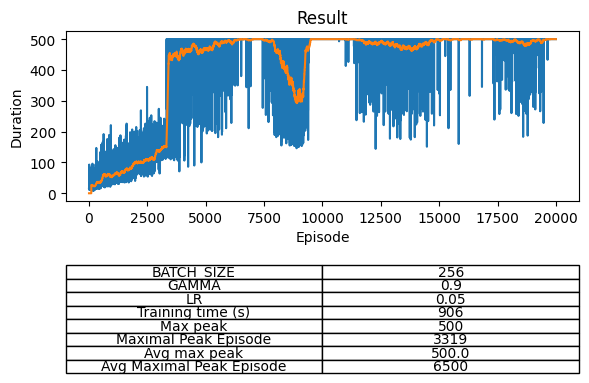

In [10]:
episode_durations = []

### Main script ###
env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 256
GAMMA = 0.9
LR = 5e-2

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = PolicyEstimatorLarger(n_observations, n_actions)

optimizer = optim.AdamW(policy_net.network.parameters(), lr=LR, amsgrad=True)
action_space = np.arange(env.action_space.n)

steps_done = 0


if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 20000
else:
    num_episodes = 15000

total_rewards, batch_rewards, batch_observations, batch_actions = [], [], [], []
batch_counter = 1

t1 = datetime.now()
training_time = 0
max_peak = 0
avg_max_peak = 0
max_peak_episode = 0
avg_max_episode = 0

pbar = trange(num_episodes, desc="Training episodes")

#for i_episode in range(num_episodes):
for i_episode in pbar:
    # Initialize the environment and get its state
    rewards, actions, observations = [], [], []
    observation, info = env.reset()
    #state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action_probs = policy_net.predict(observation).detach().numpy()
        action = np.random.choice(action_space, p=action_probs)  # randomly select an action weighted by its probability

        # push all episodic data, move to next observation
        observations.append(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)
        actions.append(action)

        done = terminated or truncated

        if done:
            #print(i_episode, t)
            #tqdm.write(f"Episode {i_episode}, steps: {t}")
            if t > max_peak:
                max_peak = t+1
                max_peak_episode = i_episode
            # apply discount to rewards
            r = np.full(len(rewards), GAMMA) ** np.arange(len(rewards)) * np.array(rewards)
            r = r[::-1].cumsum()[::-1]
            discounted_rewards = r - r.mean()

            # collect the per-batch rewards, observations, actions
            batch_rewards.extend(discounted_rewards)
            batch_observations.extend(observations)
            batch_actions.extend(actions)
            batch_counter += 1
            total_rewards.append(sum(rewards))

            if batch_counter >= BATCH_SIZE:
                # reset gradient
                optimizer.zero_grad()

                # tensorify things
                batch_rewards = torch.FloatTensor(batch_rewards)
                batch_observationss = torch.FloatTensor(batch_observations)
                batch_actions = torch.LongTensor(batch_actions)

                # calculate loss
                logprob = torch.log(policy_net.predict(batch_observations))
                batch_actions = batch_actions.reshape(len(batch_actions), 1)
                selected_logprobs = batch_rewards * torch.gather(logprob, 1, batch_actions).squeeze()
                loss = -selected_logprobs.mean()

                # backprop/optimize
                loss.backward()
                optimizer.step()

                # reset the batch
                batch_rewards, batch_observations, batch_actions = [], [], []
                batch_counter = 1

            # get running average of last 100 rewards, print every 100 episodes
            average_reward = np.mean(total_rewards[-100:])
            if i_episode % 100 == 0:
                #print(f"average of last 100 rewards as of episode {i_episode}: {average_reward:.2f}")
                #tqdm.write(f"Average last 100 rewards at episode {i_episode}: {average_reward:.2f}")
                if average_reward > avg_max_peak:
                    avg_max_peak = average_reward
                    avg_max_episode = i_episode

            pbar.set_postfix(
                episode=i_episode,
                steps=t,
                avg_reward=float(average_reward)
            )
            #
            # # quit early if average_reward is high enough
            # if early_exit_reward_amount and average_reward > early_exit_reward_amount:
            #     return total_rewards
            #
            # break

            episode_durations.append(t + 1)
            #plot_durations()
            break

t2 = datetime.now()
training_time = t2 - t1
training_time = int(training_time.total_seconds())
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

# Multi-layer Model

In [6]:
class PolicyEstimatorMultiLayer():
    def __init__(self, n_observations, n_actions):
        self.num_observations = n_observations
        self.num_actions = n_actions

        self.network = nn.Sequential(
            nn.Linear(self.num_observations, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, self.num_actions),
            nn.Softmax(dim=-1)
        )

    def predict(self, observation):
        return self.network(torch.FloatTensor(observation))

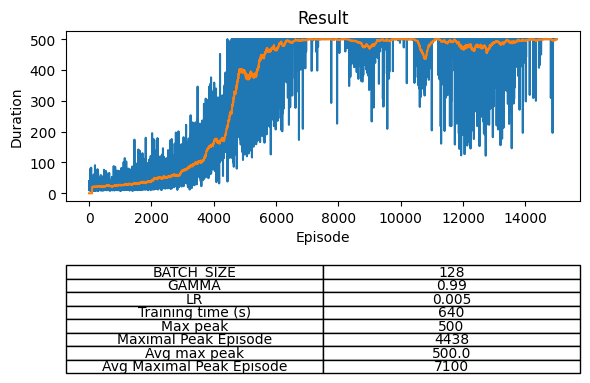

In [7]:
episode_durations = []

### Main script ###
env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
LR = 5e-3

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = PolicyEstimatorMultiLayer(n_observations, n_actions)

optimizer = optim.AdamW(policy_net.network.parameters(), lr=LR, amsgrad=True)
action_space = np.arange(env.action_space.n)

steps_done = 0


if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 15000
else:
    num_episodes = 15000

total_rewards, batch_rewards, batch_observations, batch_actions = [], [], [], []
batch_counter = 1

t1 = datetime.now()
training_time = 0
max_peak = 0
avg_max_peak = 0
max_peak_episode = 0
avg_max_episode = 0

pbar = trange(num_episodes, desc="Training episodes")

#for i_episode in range(num_episodes):
for i_episode in pbar:
    # Initialize the environment and get its state
    rewards, actions, observations = [], [], []
    observation, info = env.reset()
    #state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action_probs = policy_net.predict(observation).detach().numpy()
        action = np.random.choice(action_space, p=action_probs)  # randomly select an action weighted by its probability

        # push all episodic data, move to next observation
        observations.append(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)
        actions.append(action)

        done = terminated or truncated

        if done:
            #print(i_episode, t)
            #tqdm.write(f"Episode {i_episode}, steps: {t}")
            if t > max_peak:
                max_peak = t+1
                max_peak_episode = i_episode
            # apply discount to rewards
            r = np.full(len(rewards), GAMMA) ** np.arange(len(rewards)) * np.array(rewards)
            r = r[::-1].cumsum()[::-1]
            discounted_rewards = r - r.mean()

            # collect the per-batch rewards, observations, actions
            batch_rewards.extend(discounted_rewards)
            batch_observations.extend(observations)
            batch_actions.extend(actions)
            batch_counter += 1
            total_rewards.append(sum(rewards))

            if batch_counter >= BATCH_SIZE:
                # reset gradient
                optimizer.zero_grad()

                # tensorify things
                batch_rewards = torch.FloatTensor(batch_rewards)
                batch_observationss = torch.FloatTensor(batch_observations)
                batch_actions = torch.LongTensor(batch_actions)

                # calculate loss
                logprob = torch.log(policy_net.predict(batch_observations))
                batch_actions = batch_actions.reshape(len(batch_actions), 1)
                selected_logprobs = batch_rewards * torch.gather(logprob, 1, batch_actions).squeeze()
                loss = -selected_logprobs.mean()

                # backprop/optimize
                loss.backward()
                optimizer.step()

                # reset the batch
                batch_rewards, batch_observations, batch_actions = [], [], []
                batch_counter = 1

            # get running average of last 100 rewards, print every 100 episodes
            average_reward = np.mean(total_rewards[-100:])
            if i_episode % 100 == 0:
                #print(f"average of last 100 rewards as of episode {i_episode}: {average_reward:.2f}")
                #tqdm.write(f"Average last 100 rewards at episode {i_episode}: {average_reward:.2f}")
                if average_reward > avg_max_peak:
                    avg_max_peak = average_reward
                    avg_max_episode = i_episode

            pbar.set_postfix(
                episode=i_episode,
                steps=t,
                avg_reward=float(average_reward)
            )
            #
            # # quit early if average_reward is high enough
            # if early_exit_reward_amount and average_reward > early_exit_reward_amount:
            #     return total_rewards
            #
            # break

            episode_durations.append(t + 1)
            #plot_durations()
            break

t2 = datetime.now()
training_time = t2 - t1
training_time = int(training_time.total_seconds())
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

### Deep model

In [12]:
class PolicyEstimatorDeep():
    def __init__(self, n_observations, n_actions):
        self.num_observations = n_observations
        self.num_actions = n_actions

        self.network = nn.Sequential(
            nn.Linear(self.num_observations, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, self.num_actions),
            nn.Softmax(dim=-1)
        )

    def predict(self, observation):
        return self.network(torch.FloatTensor(observation))


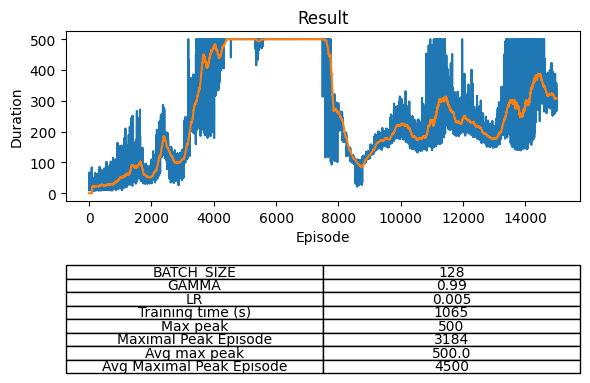

In [13]:
episode_durations = []

### Main script ###
env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
LR = 5e-3

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = PolicyEstimatorDeep(n_observations, n_actions)

optimizer = optim.AdamW(policy_net.network.parameters(), lr=LR, amsgrad=True)
action_space = np.arange(env.action_space.n)

steps_done = 0


if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 15000
else:
    num_episodes = 15000

total_rewards, batch_rewards, batch_observations, batch_actions = [], [], [], []
batch_counter = 1

t1 = datetime.now()
training_time = 0
max_peak = 0
avg_max_peak = 0
max_peak_episode = 0
avg_max_episode = 0

pbar = trange(num_episodes, desc="Training episodes")

#for i_episode in range(num_episodes):
for i_episode in pbar:
    # Initialize the environment and get its state
    rewards, actions, observations = [], [], []
    observation, info = env.reset()
    #state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action_probs = policy_net.predict(observation).detach().numpy()
        action = np.random.choice(action_space, p=action_probs)  # randomly select an action weighted by its probability

        # push all episodic data, move to next observation
        observations.append(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)
        actions.append(action)

        done = terminated or truncated

        if done:
            #print(i_episode, t)
            #tqdm.write(f"Episode {i_episode}, steps: {t}")
            if t > max_peak:
                max_peak = t+1
                max_peak_episode = i_episode
            # apply discount to rewards
            r = np.full(len(rewards), GAMMA) ** np.arange(len(rewards)) * np.array(rewards)
            r = r[::-1].cumsum()[::-1]
            discounted_rewards = r - r.mean()

            # collect the per-batch rewards, observations, actions
            batch_rewards.extend(discounted_rewards)
            batch_observations.extend(observations)
            batch_actions.extend(actions)
            batch_counter += 1
            total_rewards.append(sum(rewards))

            if batch_counter >= BATCH_SIZE:
                # reset gradient
                optimizer.zero_grad()

                # tensorify things
                batch_rewards = torch.FloatTensor(batch_rewards)
                batch_observationss = torch.FloatTensor(batch_observations)
                batch_actions = torch.LongTensor(batch_actions)

                # calculate loss
                logprob = torch.log(policy_net.predict(batch_observations))
                batch_actions = batch_actions.reshape(len(batch_actions), 1)
                selected_logprobs = batch_rewards * torch.gather(logprob, 1, batch_actions).squeeze()
                loss = -selected_logprobs.mean()

                # backprop/optimize
                loss.backward()
                optimizer.step()

                # reset the batch
                batch_rewards, batch_observations, batch_actions = [], [], []
                batch_counter = 1

            # get running average of last 100 rewards, print every 100 episodes
            average_reward = np.mean(total_rewards[-100:])
            if i_episode % 100 == 0:
                #print(f"average of last 100 rewards as of episode {i_episode}: {average_reward:.2f}")
                #tqdm.write(f"Average last 100 rewards at episode {i_episode}: {average_reward:.2f}")
                if average_reward > avg_max_peak:
                    avg_max_peak = average_reward
                    avg_max_episode = i_episode

            pbar.set_postfix(
                episode=i_episode,
                steps=t,
                avg_reward=float(average_reward)
            )
            #
            # # quit early if average_reward is high enough
            # if early_exit_reward_amount and average_reward > early_exit_reward_amount:
            #     return total_rewards
            #
            # break

            episode_durations.append(t + 1)
            #plot_durations()
            break

t2 = datetime.now()
training_time = t2 - t1
training_time = int(training_time.total_seconds())
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()